In [ ]:
!pip install biopython

In [ ]:
from google.colab import drive
import numpy as np
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
def needleman_wunsch(seq1, seq2):
    match_score = 1
    mismatch_penalty = -1
    gap_penalty = -2
    m, n = len(seq1), len(seq2)
    score = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    # Initialize first row and column
    for i in range(m + 1):
        score[i][0] = i * gap_penalty
    for j in range(n + 1):
        score[0][j] = j * gap_penalty

    # Fill the scoring matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_penalty)
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(match, delete, insert)

    best_score = score[m][n]

    # Traceback to collect up to 10 alignments
    MAX_ALIGNMENTS = 10
    results = set()

    def traceback(i, j, aligned1="", aligned2=""):
        if len(results) >= MAX_ALIGNMENTS:
            return
        if i == 0 and j == 0:
            results.add((aligned1[::-1], aligned2[::-1]))
            return
        if i > 0 and j > 0:
            diag = score[i - 1][j - 1]
            if score[i][j] == diag + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_penalty):
                traceback(i - 1, j - 1, aligned1 + seq1[i - 1], aligned2 + seq2[j - 1])
        if i > 0 and score[i][j] == score[i - 1][j] + gap_penalty:
            traceback(i - 1, j, aligned1 + seq1[i - 1], aligned2 + "-")
        if j > 0 and score[i][j] == score[i][j - 1] + gap_penalty:
            traceback(i, j - 1, aligned1 + "-", aligned2 + seq2[j - 1])

    traceback(m, n)

    return best_score, list(results)


To cluster we don't need the alignments, just the scores.(Wrote this new function to just save time.)

In [ ]:
def needleman_wunsch_score(seq1, seq2):
    match_score = 1
    mismatch_penalty = -1
    gap_penalty = -2
    m, n = len(seq1), len(seq2)
    score = [[0 for _ in range(n + 1)] for _ in range(m + 1)]

    # Initialize first row and column
    for i in range(m + 1):
        score[i][0] = i * gap_penalty
    for j in range(n + 1):
        score[0][j] = j * gap_penalty

    # Fill the scoring matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + (match_score if seq1[i - 1] == seq2[j - 1] else mismatch_penalty)
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(match, delete, insert)

    return score[m][n]


In [ ]:
import gzip
from Bio import SeqIO

fastq_gz_path = "/content/drive/My Drive/Clustering Through Alignment/zipped_rna_seq/GLDS-255_rna_seq_GSM3932708_trimmed.fastq.gz"


In [ ]:
reads = []
with gzip.open(fastq_gz_path, "rt") as handle:  # "rt" = read text mode
    for record in SeqIO.parse(handle, "fastq"):
        reads.append(str(record.seq))

In [ ]:
len(reads)

20354815

In [ ]:
# Select every 10,001st read
reduced_reads = reads[::10001]
len(reduced_reads)

2036

In [ ]:
num_reads = len(reduced_reads)
similarity_matrix = np.zeros((num_reads, num_reads))

In [ ]:
# Fill similarity matrix
for i in range(num_reads):
    for j in range(i + 1, num_reads):
        score = needleman_wunsch_score(reduced_reads[i], reduced_reads[j])
        similarity_matrix[i][j] = similarity_matrix[j][i] = score

# save so we don't have to redo alignment

In [ ]:
write_path = "/content/drive/My Drive/Clustering Through Alignment/Global_similarity_matrix.csv"

In [ ]:
write_path2 = "/content/drive/My Drive/Clustering Through Alignment/Global_reduced_reads.csv"

In [ ]:
from posix import write
np.savetxt(write_path, similarity_matrix, delimiter=",")

In [ ]:
np.savetxt(write_path2, reduced_reads, delimiter=",", fmt="%s")

# Reading the csv and reads into colab

In [ ]:
Read_path = "/content/drive/My Drive/Clustering Through Alignment/Global_similarity_matrix.csv"

In [ ]:
Read_path2 = "/content/drive/My Drive/Clustering Through Alignment/Global_reduced_reads.csv"

In [ ]:
similarity_matrix = np.loadtxt(Read_path, delimiter=",")

In [ ]:
reduced_reads = np.loadtxt(Read_path2, delimiter=",", dtype=str)

In [ ]:
similarity_matrix.shape

(2036, 2036)

# Clustering

In [ ]:
# Convert to distance matrix: higher score = smaller distance
max_score = np.max(similarity_matrix)
distance_matrix = max_score - similarity_matrix

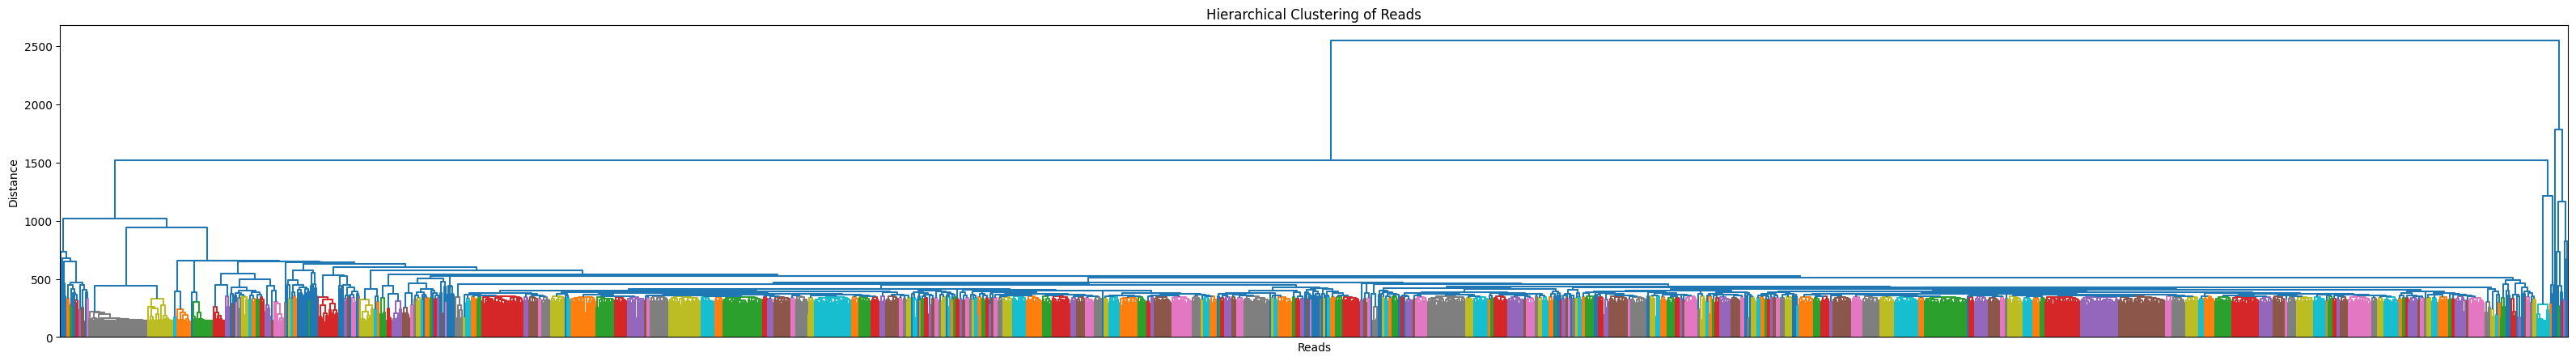

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform clustering
linked = linkage(distance_matrix, 'average')

plt.figure(figsize=(40, 5))
dendrogram(
    linked,
    no_labels=True,
    color_threshold=350,
)
plt.xlabel("Reads")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering of Reads")
plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster

clusters = fcluster(linked, t=350, criterion='distance')
print("Cluster assignments:", clusters)

Cluster assignments: [362 262 173 ... 167 173  30]


number of reads per cluster

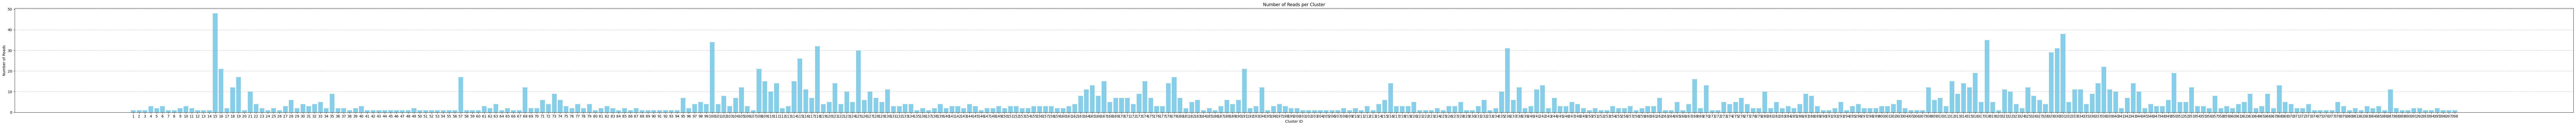

In [ ]:
from collections import Counter

# Count number of reads per cluster
cluster_counts = Counter(clusters)

# Sort clusters for cleaner plot
sorted_clusters = sorted(cluster_counts.items())
labels, counts = zip(*sorted_clusters)

# Plot
plt.figure(figsize=(100, 5))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Reads")
plt.title("Number of Reads per Cluster")
plt.xticks(labels)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Testing on Cluster 100

In [ ]:
# Find indices of reads belonging to cluster 48
cluster_100_indices = np.where(clusters == 100)[0]

# Extract the sequences
cluster_100_reads = [reduced_reads[i] for i in cluster_100_indices]

print(f"Number of reads in cluster 100: {len(cluster_100_reads)}")
for read in cluster_100_reads[:5]:
    print(read)


Number of reads in cluster 100: 34
ATCAAAGATATCCTAGGTATCCTAATCATATTCTTAATTCTCATAACCCTAGTATTATTTTTCCCAGACATACTAGGAGACCCAGACAACTACATACC
TTCCTATTTTATACCCTAATCGGTTCTATTCCACTGCTAATTGCCCTCATCTTAATCCAAAACCATGTAGGAACCCTAAACCTCATAATTTTATCATTC
ATGCAGATAAAACTCCATTTCACCCCTACTATACAATCAAAGATATCCTAGGTATCCTAATCATATTCTTAATTCTCATAACCCTAGTATTATTTTTCCC
CCCATTCCAACTTGGTCTACAAGACGCCACATCCCCTATTATAGAAGAGCTAATAAATTTCCATGATCACACACTAATAATTGTTTTCCTAATT
AAATGAACGAAAATCTATTTGCCTCATTCATTACCCCAACAATAATAGGATTCCCAATCGTTGTAGCCATCATTATATTTCCTTCAATCCTATTCCCATC


In [ ]:
from Bio.Blast import NCBIWWW
from Bio.Blast import NCBIXML
import time
import warnings
from Bio import BiopythonWarning
import concurrent.futures

In [ ]:
blast_results = []

for idx, read in enumerate(cluster_100_reads):
    print(f"BLASTing read {idx+1}/{len(cluster_100_reads)}...")

    try:
        # Suppress warnings (e.g., long BLAST time) so they don't interrupt the loop
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", BiopythonWarning)
            result_handle = NCBIWWW.qblast("blastn", "nt", read, hitlist_size=1)
            blast_record = NCBIXML.read(result_handle)

        # Save result if there's a valid hit
        if blast_record.alignments:
            alignment = blast_record.alignments[0]
            hit_def = alignment.hit_def
            e_value = alignment.hsps[0].expect
            blast_results.append((read, hit_def, e_value))
        else:
            blast_results.append((read, "No hit found", None))

    except Exception as e:
        print(f"Skipping read {idx+1} due to error: {e}")
        continue  # Skip to next read

    time.sleep(5)  # Be nice to NCBI

print("Finished BLASTing all reads!")

BLASTing read 1/34...
BLASTing read 2/34...
BLASTing read 3/34...
BLASTing read 4/34...
BLASTing read 5/34...
BLASTing read 6/34...
BLASTing read 7/34...
BLASTing read 8/34...
BLASTing read 9/34...
BLASTing read 10/34...
BLASTing read 11/34...
BLASTing read 12/34...
BLASTing read 13/34...
BLASTing read 14/34...
BLASTing read 15/34...
BLASTing read 16/34...
BLASTing read 17/34...
BLASTing read 18/34...
BLASTing read 19/34...
BLASTing read 20/34...
BLASTing read 21/34...
BLASTing read 22/34...
BLASTing read 23/34...
BLASTing read 24/34...
BLASTing read 25/34...
BLASTing read 26/34...
BLASTing read 27/34...
BLASTing read 28/34...
BLASTing read 29/34...
BLASTing read 30/34...
BLASTing read 31/34...
BLASTing read 32/34...
BLASTing read 33/34...
BLASTing read 34/34...
Finished BLASTing all reads!


In [ ]:
for read, hit, e_value in blast_results:
    print(f"Top hit: {hit} | e-value: {e_value}")

Top hit: Mus musculus isolate SY3376 cytochrome b (CYTB) gene, partial cds; mitochondrial | e-value: 1.35416e-40
Top hit: Mus spretus strain STF isolate SX4999 mitochondrion, complete genome | e-value: 3.94332e-41
Top hit: Mus musculus isolate SY3376 cytochrome b (CYTB) gene, partial cds; mitochondrial | e-value: 4.88143e-40
Top hit: Mus spretus strain STF isolate SX4999 mitochondrion, complete genome | e-value: 1.87796e-38
Top hit: Mus musculus domesticus strain WLA isolate FB65 mitochondrion, complete genome | e-value: 1.148e-41
Top hit: Mus spretus strain STF isolate SX4999 mitochondrion, complete genome | e-value: 4.88143e-40
Top hit: Mus spretus strain STF isolate SX4999 mitochondrion, complete genome | e-value: 3.94332e-41
Top hit: Mus musculus isolate SY3376 cytochrome b (CYTB) gene, partial cds; mitochondrial | e-value: 1.148e-41
Top hit: PREDICTED: Mus musculus cerebellar degeneration related antigen 1 (Cdr1), misc_RNA | e-value: 5.75802e-39
Top hit: Mus musculus junction-medi

# Reclustering with a lower threshold

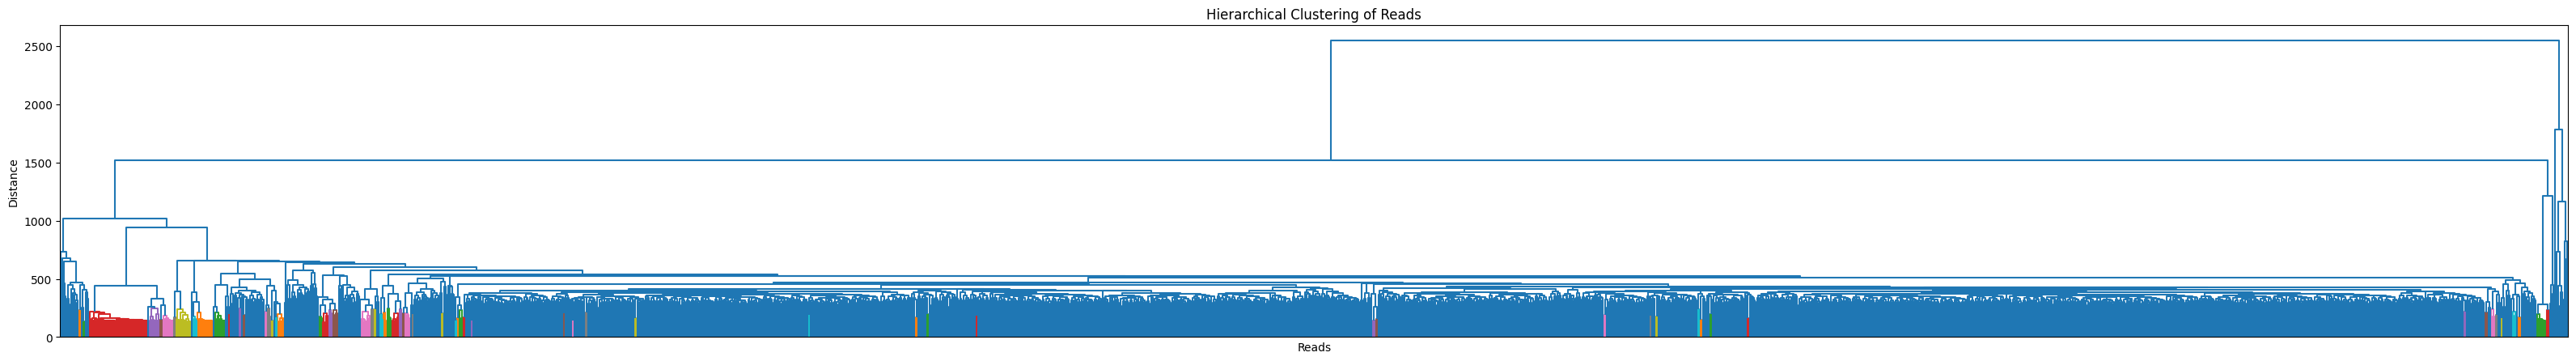

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Perform clustering
linked = linkage(distance_matrix, 'average')

plt.figure(figsize=(40, 5))
dendrogram(
    linked,
    no_labels=True,
    color_threshold=250,
)
plt.xlabel("Reads")
plt.ylabel("Distance")
plt.title("Hierarchical Clustering of Reads")
plt.show()


In [ ]:
from scipy.cluster.hierarchy import fcluster

clusters = fcluster(linked, t=250, criterion='distance')
print("Cluster assignments:", clusters)

Cluster assignments: [1750 1069  689 ...  643  688   53]


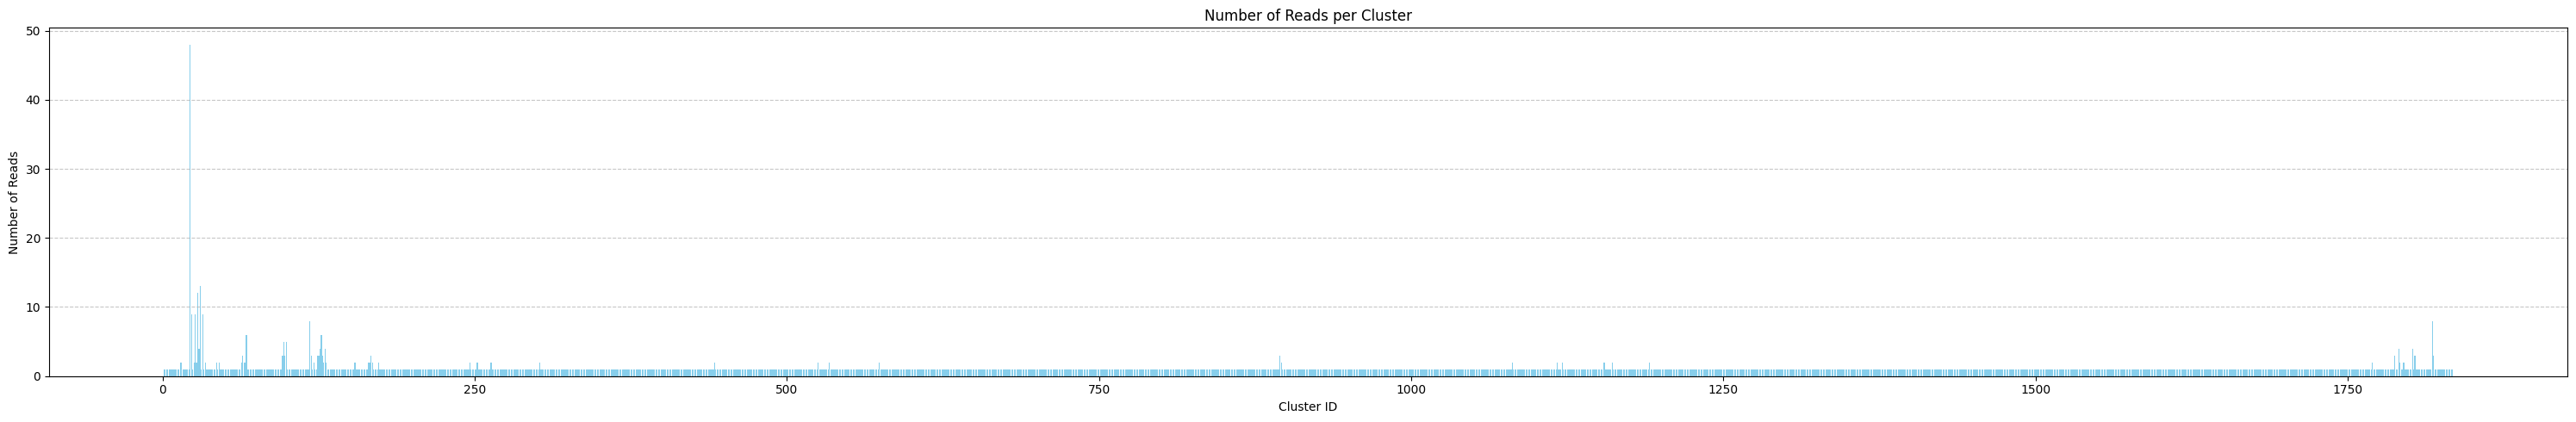

In [ ]:
from collections import Counter

# Count number of reads per cluster
cluster_counts = Counter(clusters)

# Sort clusters for cleaner plot
sorted_clusters = sorted(cluster_counts.items())
labels, counts = zip(*sorted_clusters)

# Plot
plt.figure(figsize=(30, 5))
plt.bar(labels, counts, color='skyblue')
plt.xlabel("Cluster ID")
plt.ylabel("Number of Reads")
plt.title("Number of Reads per Cluster")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

biggest cluster

In [ ]:
biggest_cluster_id, biggest_cluster_count = cluster_counts.most_common(1)[0]

print(f"Biggest cluster: {biggest_cluster_id} with {biggest_cluster_count} reads")

Biggest cluster: 22 with 48 reads


Blasting cluster 22

In [ ]:
# Find indices of reads belonging to cluster 48
cluster_22_indices = np.where(clusters == 22)[0]

# Extract the sequences
cluster_22_reads = [reduced_reads[i] for i in cluster_22_indices]

print(f"Number of reads in cluster 24: {len(cluster_22_reads)}")
for read in cluster_22_reads[:5]:
    print(read)


Number of reads in cluster 24: 48
GTGGCGCACGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGACAGGAGGATCGCTTGAGTCCAGGAGTTCTGGGCTGTAGTGCGCTATGCCGATCGGGTGT
GTGGCGCACGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGACAGGAGGATCGCTTGAGTCCAGGAGTTCTGGGCTGTAGTGCGCTATGCCGATCGGGTG
CGGTGGCGCACGCCTGTAGTCCCAGCTACACGGGAGGCTGAGACAGGAGGATCGCTTGAGTCCAGGAGTTCTGGGCTGTAGTGCGCTATGCCGATCGGG
CGGTGGCGCACGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGACAGGAGGATCGCTCGAGTCCAGGAGTTCTGGGCTGTAGTGCGCTATGCCGATCGGG
GTGGCGCACGCCTGTAGTCCCAGCTACTCGGGAGGCTGAGACAGGAGGATCGCTTGAGTCCAGGAGTTCTGGGCTGTAGTGCGCTATGCCGATCGGGTGT


In [ ]:
blast_results = []

def blast_single_read(read):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", BiopythonWarning)
        result_handle = NCBIWWW.qblast("blastn", "nt", read, hitlist_size=1)
        blast_record = NCBIXML.read(result_handle)

    if blast_record.alignments:
        alignment = blast_record.alignments[0]
        hit_def = alignment.hit_def
        e_value = alignment.hsps[0].expect
        return (read, hit_def, e_value)
    else:
        return (read, "No hit found", None)

for idx, read in enumerate(cluster_22_reads):
    print(f"BLASTing read {idx+1}/{len(cluster_22_reads)}...")

    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        future = executor.submit(blast_single_read, read)
        try:
            result = future.result(timeout=600)  # 600 seconds = 10 minutes
            blast_results.append(result)
        except concurrent.futures.TimeoutError:
            print(f"Skipping read {idx+1} due to timeout (>10 minutes)")
            continue
        except Exception as e:
            print(f"Skipping read {idx+1} due to error: {e}")
            continue

    time.sleep(5)

print("Finished BLASTing all reads!")


BLASTing read 1/48...
BLASTing read 2/48...
BLASTing read 3/48...
BLASTing read 4/48...
BLASTing read 5/48...
BLASTing read 6/48...
BLASTing read 7/48...
BLASTing read 8/48...
BLASTing read 9/48...
BLASTing read 10/48...
BLASTing read 11/48...
BLASTing read 12/48...
BLASTing read 13/48...
BLASTing read 14/48...
BLASTing read 15/48...
BLASTing read 16/48...
BLASTing read 17/48...
BLASTing read 18/48...
BLASTing read 19/48...
BLASTing read 20/48...
BLASTing read 21/48...
BLASTing read 22/48...
BLASTing read 23/48...
BLASTing read 24/48...
BLASTing read 25/48...
BLASTing read 26/48...
BLASTing read 27/48...
BLASTing read 28/48...
BLASTing read 29/48...
BLASTing read 30/48...
BLASTing read 31/48...
BLASTing read 32/48...
BLASTing read 33/48...
BLASTing read 34/48...
BLASTing read 35/48...
BLASTing read 36/48...
BLASTing read 37/48...
BLASTing read 38/48...
BLASTing read 39/48...
BLASTing read 40/48...
BLASTing read 41/48...
BLASTing read 42/48...
BLASTing read 43/48...
BLASTing read 44/48.

In [ ]:
for read, hit, e_value in blast_results:
    print(f"Top hit: {hit} | e-value: {e_value}")

Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 1.148e-41
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 3.94332e-41
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 1.67674e-39
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 1.67674e-39
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 1.148e-41
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 3.94332e-41
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 1.35416e-40
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 1.148e-41
Top hit: PREDICTED: Rattus norvegicus uncharacterized LOC134480821 (LOC134480821), ncRNA | e-value: 3.94332e-4